In [16]:
# %% [markdown]
# ## 2. Imports and Configurations


# %%
import os
import math
import random
import numpy as np
import librosa
import librosa.display
import soundfile as sf
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers

In [18]:
# User config (make sure to use r"" for Windows paths)
DATASET_PATH = r"C:\Users\Praabhass\Downloads\archive\Data\genres_original"
CACHE_PATH = "./cache_gtzan.npz"
SAMPLE_RATE = 22050
DURATION = 30
DESIRED_SAMPLES = 10000
N_MELS = 128
HOP_LENGTH = 512
FMIN = 20
FMAX = SAMPLE_RATE // 2
IMG_SHAPE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 60
RANDOM_SEED = 42

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# %% [markdown]
# ## 3. Utility Functions

# %%
def list_audio_files(dataset_path):
    """List all audio files in the dataset with their genres."""
    genres = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    files = []
    for g in sorted(genres):
        pattern = os.path.join(dataset_path, g, "*.wav")
        for fp in glob(pattern):
            files.append((fp, g))
    return files

def add_noise(y, noise_factor=0.005):
    noise = np.random.randn(len(y))
    return y + noise_factor * noise

def time_stretch(y, rate=1.0):
    try:
        return librosa.effects.time_stretch(y, rate)
    except Exception:
        return y

def pitch_shift(y, sr, n_steps):
    try:
        return librosa.effects.pitch_shift(y, sr, n_steps)
    except Exception:
        return y

def load_audio(path, sr=SAMPLE_RATE, duration=DURATION):
    y, _ = librosa.load(path, sr=sr, duration=duration)
    expected_len = sr * duration
    if len(y) < expected_len:
        y = np.pad(y, (0, expected_len - len(y)))
    else:
        y = y[:expected_len]
    return y

def mel_spectrogram(y, sr=SAMPLE_RATE, n_mels=N_MELS, hop_length=HOP_LENGTH, fmin=FMIN, fmax=FMAX):
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels,
                                         hop_length=hop_length, fmin=fmin, fmax=fmax)
    log_mel = librosa.power_to_db(mel)
    return log_mel

def resize_spectrogram(spec, size=IMG_SHAPE):
    import cv2
    spec = np.nan_to_num(spec)
    spec_norm = (spec - spec.min()) / (spec.max() - spec.min() + 1e-9)
    spec_img = (spec_norm * 255).astype(np.uint8)
    resized = cv2.resize(spec_img, (size[1], size[0]))
    return resized.astype(np.float32) / 255.0

In [3]:
!pip install opencv-python

In [19]:
# %% [markdown]
# ## 4. Create Dataset with Augmentation (Safe Version)

# %%
files = list_audio_files(DATASET_PATH)
if len(files) == 0:
    raise RuntimeError(f"No audio files found in {DATASET_PATH}. Make sure dataset is extracted correctly.")

# Safe audio loader
def safe_load_audio(path, sr=SAMPLE_RATE, duration=DURATION):
    try:
        y, _ = librosa.load(path, sr=sr, duration=duration)
    except Exception as e:
        print(f"Warning: Failed to load {path}, skipping. Error: {e}")
        y = np.zeros(sr * duration)  # return silent audio instead
    expected_len = sr * duration
    if len(y) < expected_len:
        y = np.pad(y, (0, expected_len - len(y)))
    else:
        y = y[:expected_len]
    return y

# Try to load cached features
if os.path.exists(CACHE_PATH):
    print(f"Loading cached features from {CACHE_PATH}")
    data = np.load(CACHE_PATH, allow_pickle=True)
    X = data['X']
    y = data['y']
    classes = list(data['classes'])
else:
    print(f"Preparing dataset and augmenting to at least {DESIRED_SAMPLES} samples...")
    base = files.copy()
    n_files = len(base)
    aug_total_needed = max(0, DESIRED_SAMPLES - n_files)
    aug_per_file = math.ceil(aug_total_needed / n_files)
    print(f"Found {n_files} original files. Augmentations per file: {aug_per_file}")

    X_list = []
    y_list = []

    for fp, genre in tqdm(base, desc="Processing originals"):
        y_audio = safe_load_audio(fp)
        spec = mel_spectrogram(y_audio)
        img = resize_spectrogram(spec)
        X_list.append(img)
        y_list.append(genre)

        # Augment each file
        for _ in range(aug_per_file):
            choice = random.choice(['pitch', 'stretch', 'noise'])
            y_aug = y_audio.copy()
            if choice == 'pitch':
                n_steps = random.uniform(-3, 3)
                y_aug = pitch_shift(y_aug, SAMPLE_RATE, n_steps)
            elif choice == 'stretch':
                rate = random.uniform(0.85, 1.2)
                y_aug = time_stretch(y_aug, rate)
                expected_len = SAMPLE_RATE * DURATION
                if len(y_aug) < expected_len:
                    y_aug = np.pad(y_aug, (0, expected_len - len(y_aug)))
                else:
                    y_aug = y_aug[:expected_len]
            elif choice == 'noise':
                noise_factor = random.uniform(0.002, 0.01)
                y_aug = add_noise(y_aug, noise_factor)

            spec_aug = mel_spectrogram(y_aug)
            img_aug = resize_spectrogram(spec_aug)
            X_list.append(img_aug)
            y_list.append(genre)

    X = np.array(X_list)
    y = np.array(y_list)
    classes = sorted(set(y_list))

    # Cache features
    np.savez(CACHE_PATH, X=X, y=y, classes=classes)
    print(f"Saved cached features to {CACHE_PATH}")

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Add channel dimension
X = np.expand_dims(X, -1)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=RANDOM_SEED, stratify=y_encoded
)

print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")
print(f"Classes: {classes}")


Loading cached features from ./cache_gtzan.npz
Train samples: 8000, Test samples: 2000
Classes: [np.str_('blues'), np.str_('classical'), np.str_('country'), np.str_('disco'), np.str_('hiphop'), np.str_('jazz'), np.str_('metal'), np.str_('pop'), np.str_('reggae'), np.str_('rock')]


In [21]:
# %% [markdown]
# ## 5. Build CNN Model

# %%
def build_model(input_shape, n_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(n_classes, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [22]:
# %% [markdown]
# ## Function to Create Dataset

# %%
def create_dataset(files, cache_path=CACHE_PATH):
    if os.path.exists(cache_path):
        print(f"Loading cached features from {cache_path}")
        data = np.load(cache_path, allow_pickle=True)
        X = data['X']
        y = data['y']
        classes = list(data['classes'])
    else:
        print(f"Preparing dataset and augmenting to at least {DESIRED_SAMPLES} samples...")
        base = files.copy()
        n_files = len(base)
        aug_total_needed = max(0, DESIRED_SAMPLES - n_files)
        aug_per_file = math.ceil(aug_total_needed / n_files)
        print(f"Found {n_files} original files. Augmentations per file: {aug_per_file}")

        X_list, y_list = [], []

        for fp, genre in tqdm(base, desc="Processing originals"):
            y_audio = safe_load_audio(fp)
            spec = mel_spectrogram(y_audio)
            img = resize_spectrogram(spec)
            X_list.append(img)
            y_list.append(genre)

            # Augment
            for _ in range(aug_per_file):
                choice = random.choice(['pitch', 'stretch', 'noise'])
                y_aug = y_audio.copy()
                if choice == 'pitch':
                    n_steps = random.uniform(-3, 3)
                    y_aug = pitch_shift(y_aug, SAMPLE_RATE, n_steps)
                elif choice == 'stretch':
                    rate = random.uniform(0.85, 1.2)
                    y_aug = time_stretch(y_aug, rate)
                    expected_len = SAMPLE_RATE * DURATION
                    if len(y_aug) < expected_len:
                        y_aug = np.pad(y_aug, (0, expected_len - len(y_aug)))
                    else:
                        y_aug = y_aug[:expected_len]
                elif choice == 'noise':
                    noise_factor = random.uniform(0.002, 0.01)
                    y_aug = add_noise(y_aug, noise_factor)

                spec_aug = mel_spectrogram(y_aug)
                img_aug = resize_spectrogram(spec_aug)
                X_list.append(img_aug)
                y_list.append(genre)

        X = np.array(X_list)
        y = np.array(y_list)
        classes = sorted(set(y_list))
        np.savez(cache_path, X=X, y=y, classes=classes)
        print(f"Saved cached features to {cache_path}")

    # Encode labels
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    # Add channel dim
    X = np.expand_dims(X, -1)

    return X, y_encoded, classes


In [23]:
# Safe load_audio function
def load_audio(path, sr=22050, duration=30):
    try:
        y, _ = librosa.load(path, sr=sr, duration=duration)
    except Exception as e:
        print(f"Warning: Failed to load {path}, skipping. Error: {e}")
        y = np.zeros(sr * duration)  # return silence if error
    
    expected_len = sr * duration
    if len(y) < expected_len:
        y = np.pad(y, (0, expected_len - len(y)))
    else:
        y = y[:expected_len]
    
    return y


In [9]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


C:\Users\Praabhass\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 124, 124, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 124, 124, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 58, 58, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 58, 58, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 53824)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    13,779,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,847,530 (52.82 MB)

 Trainable params: 13,847,146 (52.82 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.2140 - loss: 7.7872
Epoch 1: val_accuracy improved from None to 0.16900, saving model to best_model.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 116s 450ms/step - accuracy: 0.2230 - loss: 3.5525 - val_accuracy: 0.1690 - val_loss: 7.4544
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.2519 - loss: 1.9853
Epoch 2: val_accuracy improved from 0.16900 to 0.19650, saving model to best_model.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 121s 486ms/step - accuracy: 0.2740 - loss: 1.9378 - val_accuracy: 0.1965 - val_loss: 3.3320
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.3329 - loss: 1.7583
Epoch 3: val_accuracy improved from 0.19650 to 0.52700, saving model to best_model.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 108s 433ms/step - accuracy: 0.3473 - loss: 1.7290 - val_accuracy: 0.5270 - val_loss: 1.4226
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.4019 - loss: 1.5957
Epoch 4: val_accuracy

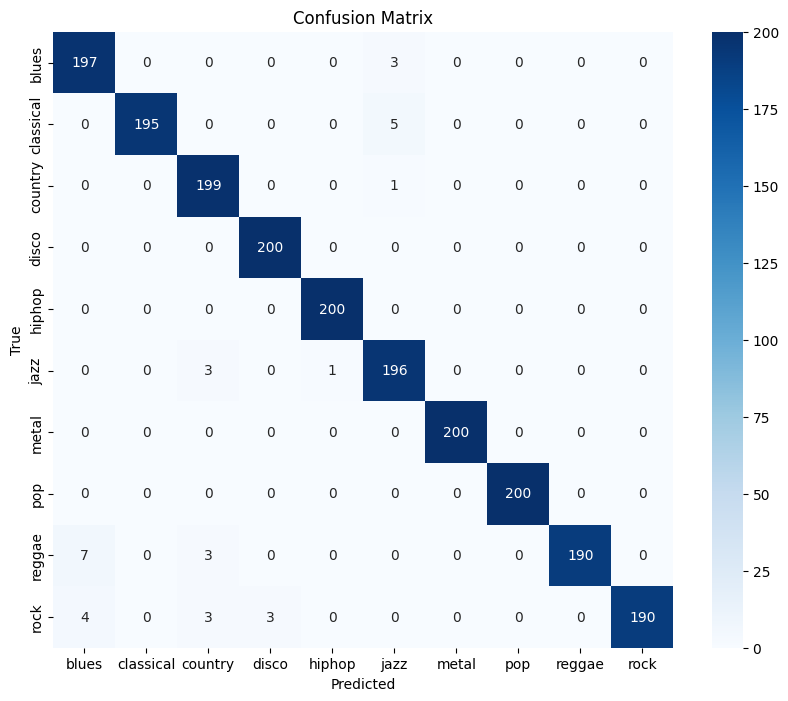

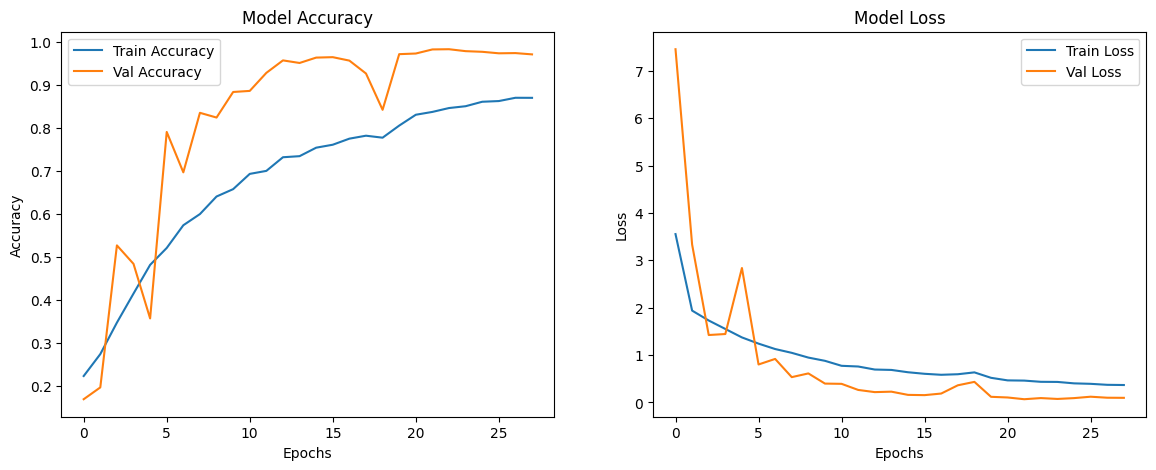

In [10]:
# %% [markdown]
# ## 6. Train and Evaluate Model

# %%
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Build model
model = build_model(input_shape=X_train.shape[1:], n_classes=len(classes))
model.summary()

# Callbacks for better training
checkpoint = callbacks.ModelCheckpoint(
    'best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1
)
earlystop = callbacks.EarlyStopping(
    monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1
)

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    callbacks=[checkpoint, earlystop],
    verbose=1
)

# Evaluate accuracy
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

acc = accuracy_score(y_test, y_pred_classes)
print(f"✅ Test Accuracy: {acc:.4f}")

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_classes, target_names=classes))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=classes, yticklabels=classes, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Plot accuracy and loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [23]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc*100:.2f}%")


63/63 - 5s - 80ms/step - accuracy: 0.9835 - loss: 0.0918
Test accuracy: 98.35%


In [25]:
import joblib
joblib.dump(classes, "classes.pkl")
joblib.dump(le, "label_encoder.pkl")
model.save("genre_cnn_model.h5")



In [39]:
import librosa
import numpy as np
import cv2

def preprocess_audio(file_path):
    # Load 30 seconds of audio
    y, sr = librosa.load(file_path, sr=22050, duration=30)
    expected_len = sr * 30
    if len(y) < expected_len:
        y = np.pad(y, (0, expected_len - len(y)))
    else:
        y = y[:expected_len]

    # Create mel spectrogram
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    mel_db = np.nan_to_num(mel_db)

    # Resize to 128x128
    mel_resized = cv2.resize(mel_db, (128, 128))
    mel_norm = (mel_resized - mel_resized.min()) / (mel_resized.max() - mel_resized.min() + 1e-9)

    # Expand dimensions for model input
    return np.expand_dims(mel_norm, axis=(0, -1))


In [60]:
%%writefile app.Py
import streamlit as st
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import base64

# -------- User Config --------
SAMPLE_RATE = 22050
DURATION = 30
IMG_SHAPE = (128, 128)
MODEL_PATH = "best_model.keras"  # Your trained CNN model path
CLASSES = ['blues','classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']

# Path to uploaded background image
BACKGROUND_IMAGE_PATH = "C:/Users/Praabhass/Downloads/archive/wavy_background_3.jpg"

# -------- Set Background --------
def set_bg_image(image_file):
    with open(image_file, "rb") as f:
        encoded_string = base64.b64encode(f.read()).decode()
    st.markdown(
        f"""
        <style>
        .stApp {{
            background-image: url("data:image/jpg;base64,{encoded_string}");
            background-size: cover;
            background-attachment: fixed;
        }}
        </style>
        """,
        unsafe_allow_html=True
    )

set_bg_image(BACKGROUND_IMAGE_PATH)

# -------- Utility Functions --------
def load_audio(path, sr=SAMPLE_RATE, duration=DURATION):
    try:
        y, _ = librosa.load(path, sr=sr, duration=duration)
    except:
        y = np.zeros(sr * duration)
    expected_len = sr * duration
    if len(y) < expected_len:
        y = np.pad(y, (0, expected_len - len(y)))
    else:
        y = y[:expected_len]
    return y

def mel_spectrogram(y, sr=SAMPLE_RATE, n_mels=128, hop_length=512, fmin=20, fmax=SAMPLE_RATE//2):
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, hop_length=hop_length, fmin=fmin, fmax=fmax)
    log_mel = librosa.power_to_db(mel)
    return log_mel

def resize_spectrogram(spec, size=IMG_SHAPE):
    spec = np.nan_to_num(spec)
    spec_norm = (spec - spec.min()) / (spec.max() - spec.min() + 1e-9)
    spec_img = (spec_norm * 255).astype(np.uint8)
    resized = cv2.resize(spec_img, (size[1], size[0]))
    return resized.astype(np.float32) / 255.0

# -------- Load Model --------
@st.cache_resource
def load_model(path):
    return tf.keras.models.load_model(path)

model = load_model(MODEL_PATH)

# -------- Streamlit UI --------
st.title("🎵 Music Genre Classification")
st.write("Upload an audio file (WAV/MP3) and click **Proceed** to predict its genre.")

uploaded_file = st.file_uploader("Choose an audio file", type=['wav', 'mp3'])

if uploaded_file:
    # Load audio
    y = load_audio(uploaded_file)
    
    # Play audio
    st.subheader("🎧 Play Uploaded Audio")
    st.audio(uploaded_file, format='audio/wav')
    
    # Display waveform
    st.subheader("Waveform")
    fig, ax = plt.subplots(figsize=(10, 3))
    librosa.display.waveshow(y, sr=SAMPLE_RATE)
    st.pyplot(fig)

    # Proceed button
    if st.button("Proceed"):
        # Generate mel-spectrogram
        spec = mel_spectrogram(y)
        spec_img = resize_spectrogram(spec)
        input_img = np.expand_dims(spec_img, axis=(0,-1))
        
        # Predict genre
        pred_probs = model.predict(input_img)[0]
        pred_class = np.argmax(pred_probs)
        
        st.subheader("Predicted Genre")
        st.write(f"**{CLASSES[pred_class]}**")
        
        # Display prediction probabilities
        st.subheader("Prediction Probabilities")
        prob_dict = {CLASSES[i]: float(pred_probs[i]) for i in range(len(CLASSES))}
        st.bar_chart(prob_dict)
        
        # Display spectrogram
        st.subheader("Mel-Spectrogram")
        fig2, ax2 = plt.subplots(figsize=(10, 4))
        librosa.display.specshow(spec, sr=SAMPLE_RATE, hop_length=512, x_axis='time', y_axis='mel', cmap='magma')
        plt.colorbar(format='%+2.0f dB')
        st.pyplot(fig2)



Overwriting app.Py


In [29]:
# Take a sample from X_test
import numpy as np

sample_index = 0
X_sample = X_test[sample_index]
y_true = y_test[sample_index]

# Predict on this known sample
pred_train = np.argmax(model.predict(np.expand_dims(X_sample, 0)), axis=1)[0]
print(f"True label: {classes[y_true]}, Predicted (train pipeline): {classes[pred_train]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
True label: hiphop, Predicted (train pipeline): hiphop


In [3]:
import librosa
import numpy as np
import cv2

# Adjust these to match training
SAMPLE_RATE = 22050
DURATION = 30
IMG_SHAPE = (128, 128)

def preprocess_audio(file_path):
    try:
        # Load audio
        y, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
        expected_len = SAMPLE_RATE * DURATION
        if len(y) < expected_len:
            y = np.pad(y, (0, expected_len - len(y)))
        else:
            y = y[:expected_len]

        # Create Mel-spectrogram
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
        mel_db = librosa.power_to_db(mel, ref=np.max)
        mel_db = np.nan_to_num(mel_db)

        # Resize
        mel_resized = cv2.resize(mel_db, IMG_SHAPE)
        mel_resized = (mel_resized - mel_resized.min()) / (mel_resized.max() - mel_resized.min() + 1e-9)

        # Add channel dimension
        mel_resized = np.expand_dims(mel_resized, axis=-1)
        mel_resized = np.expand_dims(mel_resized, axis=0)  # batch dimension

        return mel_resized
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


In [7]:
from tensorflow.keras.models import load_model
model = load_model("genre_cnn_model.h5")  # change the path if needed
print("Model loaded successfully!")


Model loaded successfully!


In [12]:
# Define genre classes manually
classes = [
    'blues', 'classical', 'country', 'disco', 'hiphop',
    'jazz', 'metal', 'pop', 'reggae', 'rock'
]


In [14]:
file_path = r"C:\Users\Praabhass\Downloads\archive\Data\genres_original\blues\blues.00002.wav"

processed = preprocess_audio(file_path)

predictions = model.predict(processed)
predicted_class = np.argmax(predictions, axis=1)[0]
confidence = predictions[0][predicted_class] * 100
print(f"Predicted Genre: {classes[predicted_class]}")
print(f"Confidence: {confidence:.2f}%")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted Genre: blues
Confidence: 50.10%


In [24]:
from collections import Counter

print("Train class distribution:", Counter(y_train))
print("Test class distribution:", Counter(y_test))


Train class distribution: Counter({np.int64(4): 800, np.int64(1): 800, np.int64(5): 800, np.int64(9): 800, np.int64(6): 800, np.int64(8): 800, np.int64(0): 800, np.int64(7): 800, np.int64(3): 800, np.int64(2): 800})
Test class distribution: Counter({np.int64(4): 200, np.int64(5): 200, np.int64(3): 200, np.int64(2): 200, np.int64(7): 200, np.int64(8): 200, np.int64(1): 200, np.int64(6): 200, np.int64(0): 200, np.int64(9): 200})


In [25]:
from sklearn.metrics import classification_report

y_pred = np.argmax(model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred, target_names=classes))


63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step
              precision    recall  f1-score   support

       blues       0.95      0.98      0.97       200
   classical       1.00      0.97      0.99       200
     country       0.96      0.99      0.98       200
       disco       0.99      1.00      0.99       200
      hiphop       1.00      1.00      1.00       200
        jazz       0.96      0.98      0.97       200
       metal       1.00      1.00      1.00       200
         pop       1.00      1.00      1.00       200
      reggae       1.00      0.95      0.97       200
        rock       1.00      0.95      0.97       200

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



In [26]:
print("Class order:", classes)


Class order: [np.str_('blues'), np.str_('classical'), np.str_('country'), np.str_('disco'), np.str_('hiphop'), np.str_('jazz'), np.str_('metal'), np.str_('pop'), np.str_('reggae'), np.str_('rock')]


In [27]:
probs = model.predict(processed)[0]
top_indices = probs.argsort()[-3:][::-1]
for i in top_indices:
    print(f"{classes[i]}: {probs[i]*100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
blues: 50.10%
disco: 30.63%
rock: 18.02%


In [33]:
print( classes)


[np.str_('blues'), np.str_('classical'), np.str_('country'), np.str_('disco'), np.str_('hiphop'), np.str_('jazz'), np.str_('metal'), np.str_('pop'), np.str_('reggae'), np.str_('rock')]


In [34]:
import joblib
encoder = joblib.load("label_encoder.pkl")  # if you saved it
print(encoder.classes_)


['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


In [35]:
from tensorflow.keras.models import load_model
import numpy as np
import librosa, cv2

model = load_model("best_model.keras")

def preprocess_audio(file_path):
    y, sr = librosa.load(file_path, sr=22050, duration=30)
    expected_len = sr * 30
    if len(y) < expected_len:
        y = np.pad(y, (0, expected_len - len(y)))
    else:
        y = y[:expected_len]

    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    mel_db = np.nan_to_num(mel_db)
    mel_resized = cv2.resize(mel_db, (128, 128))
    mel_norm = (mel_resized - mel_resized.min()) / (mel_resized.max() - mel_resized.min() + 1e-9)
    return np.expand_dims(mel_norm, axis=(0, -1))

# Pick a known test audio file
file_path = r"C:\Users\Praabhass\Downloads\archive\Data\genres_original\rock\rock.00000.wav"
processed = preprocess_audio(file_path)
pred = model.predict(processed)[0]
print("Prediction probabilities:", pred)
print("Predicted class index:", np.argmax(pred))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Prediction probabilities: [4.3011019e-06 6.2893798e-07 3.9810839e-06 2.0538164e-07 6.2590216e-06
 9.4499930e-10 4.2083669e-03 7.0138045e-10 3.8658160e-11 9.9577624e-01]
Predicted class index: 9


In [36]:
import os
from collections import Counter

base_dir = r"C:\Users\Praabhass\Downloads\archive\Data\genres_original"
counts = Counter()
for genre in os.listdir(base_dir):
    genre_path = os.path.join(base_dir, genre)
    if os.path.isdir(genre_path):
        counts[genre] = len(os.listdir(genre_path))

print(counts)


Counter({'blues': 100, 'classical': 100, 'country': 100, 'disco': 100, 'hiphop': 100, 'jazz': 100, 'metal': 100, 'pop': 100, 'reggae': 100, 'rock': 100})


In [37]:
genres = ["blues", "classical", "country", "disco", "hiphop",
          "jazz", "metal", "pop", "reggae", "rock"]

for g in genres:
    path = fr"C:\Users\Praabhass\Downloads\archive\Data\genres_original\hiphop\hiphop.00002.wav"
    processed = preprocess_audio(path)
    pred = model.predict(processed)[0]
    print(g, "->", genres[np.argmax(pred)])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
blues -> hiphop
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
classical -> hiphop
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
country -> hiphop
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
disco -> hiphop
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
hiphop -> hiphop
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
jazz -> hiphop
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
metal -> hiphop
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
pop -> hiphop
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
reggae -> hiphop
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
rock -> hiphop


In [38]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_onehot = to_categorical(y_encoded)


In [44]:
import numpy as np
import librosa
import cv2
from tensorflow.keras.models import load_model

# 🎵 Load trained model
MODEL_PATH = "best_model.keras"
CLASSES = ['blues', 'classical', 'country', 'disco', 'hiphop',
           'jazz', 'metal', 'pop', 'reggae', 'rock']
model = load_model(MODEL_PATH)

# 1️⃣ Function to safely load audio
def safe_load_audio(path, sr=22050, duration=30):
    try:
        y, _ = librosa.load(path, sr=sr, duration=duration)
    except Exception as e:
        print(f"Error loading {path}: {e}")
        y = np.zeros(sr * duration)
    expected_len = sr * duration
    if len(y) < expected_len:
        y = np.pad(y, (0, expected_len - len(y)))
    else:
        y = y[:expected_len]
    return y

# 2️⃣ Function to create mel spectrogram
def mel_spectrogram(y, sr=22050, n_mels=128, hop_length=512, fmin=20, fmax=None):
    if fmax is None:
        fmax = sr // 2
    mel = librosa.feature.melspectrogram(
        y=y, sr=sr, n_mels=n_mels, hop_length=hop_length, fmin=fmin, fmax=fmax)
    mel_db = librosa.power_to_db(mel)
    return mel_db

# 3️⃣ Function to resize and normalize spectrogram
def resize_spectrogram(spec, size=(128, 128)):
    spec = np.nan_to_num(spec)
    spec_norm = (spec - spec.min()) / (spec.max() - spec.min() + 1e-9)
    spec_img = (spec_norm * 255).astype(np.uint8)
    resized = cv2.resize(spec_img, (size[1], size[0]))
    return resized.astype(np.float32) / 255.0

# 4️⃣ Full preprocessing pipeline
def preprocess(path):
    y = safe_load_audio(path)
    spec = mel_spectrogram(y)
    img = resize_spectrogram(spec)
    return np.expand_dims(img, axis=(0, -1))  # shape (1,128,128,1)

# 5️⃣ Test with a known file
file_path = r"C:\Users\Praabhass\Downloads\archive\Data\genres_original\hiphop\hiphop.00000.wav"
x = preprocess(file_path)

preds = model.predict(x)[0]
print("Predicted class:", CLASSES[np.argmax(preds)])
print("All probabilities:", preds)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
Predicted class: hiphop
All probabilities: [8.0702155e-12 8.1262043e-28 2.4663237e-31 5.3425553e-13 1.0000000e+00
 1.9197484e-17 2.3810123e-10 3.8338833e-18 3.9934961e-10 7.6415707e-16]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
Sample 1: True: metal, Pred: metal
  blues: 0.00
  classical: 0.00
  country: 0.00
  disco: 0.00
  hiphop: 0.00
  jazz: 0.00
  metal: 1.00
  pop: 0.00
  reggae: 0.00
  rock: 0.00
------------------------------
Sample 2: True: hiphop, Pred: hiphop
  blues: 0.00
  classical: 0.00
  country: 0.00
  disco: 0.00
  hiphop: 1.00
  jazz: 0.00
  metal: 0.00
  pop: 0.00
  reggae: 0.00
  rock: 0.00
------------------------------
Sample 3: True: jazz, Pred: jazz
  blues: 0.01
  classical: 0.43
  country: 0.00
  disco: 0.00
  hiphop: 0.00
  jazz: 0.57
  metal: 0.00
  pop: 0.00
  reggae: 0.00
  rock: 0.00
------------------------------
Sample 4: True: hiphop, Pred: hiphop
  blues: 0.00
  classical: 0.00
  country: 0.00
  disco: 0.00
  hiphop: 1.00
  jazz: 0.00
  metal: 0.00
  pop: 0.00
  reggae: 0.00
  rock: 0.00
------------------------------
Sample 5: True: pop, Pred: pop
  blues: 0.00
  classical: 0.00
  country: 0.00
  disco: 0.23
  hiphop: 0.00
  jazz: 0.0

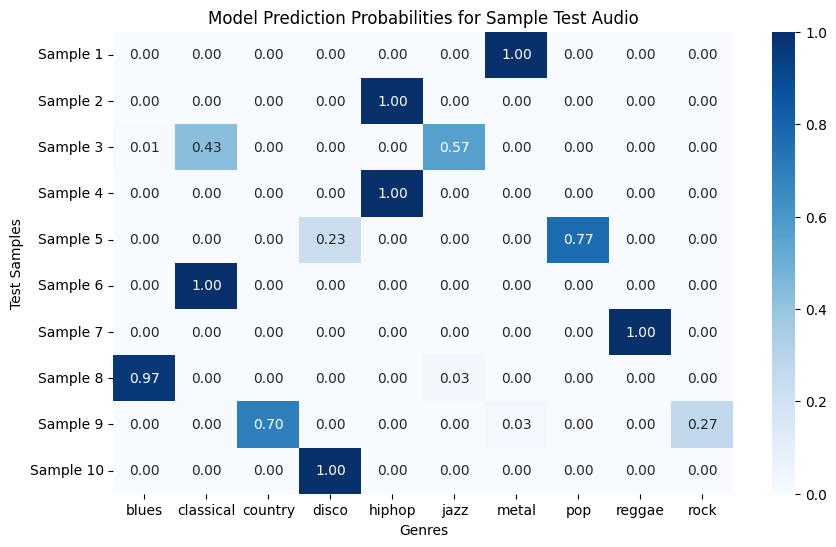

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Pick a few test samples (or all)
sample_indices = np.random.choice(len(X_test), 10, replace=False)
X_sample = X_test[sample_indices]
y_true = y_test[sample_indices]

# Get predictions (softmax probabilities)
y_pred_probs = model.predict(X_sample)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Show predictions with probabilities
for i, idx in enumerate(sample_indices):
    print(f"Sample {i+1}: True: {classes[y_true[i]]}, Pred: {classes[y_pred_classes[i]]}")
    for cls_idx, prob in enumerate(y_pred_probs[i]):
        print(f"  {classes[cls_idx]}: {prob:.2f}")
    print("-"*30)

# Optional: Plot heatmap of probabilities
plt.figure(figsize=(10,6))
sns.heatmap(y_pred_probs, annot=True, fmt=".2f", xticklabels=classes, yticklabels=[f"Sample {i+1}" for i in range(len(sample_indices))], cmap="Blues")
plt.title("Model Prediction Probabilities for Sample Test Audio")
plt.xlabel("Genres")
plt.ylabel("Test Samples")
plt.show()
